<a href="https://colab.research.google.com/github/SimeonHristov99/AI_Traffic_Sign_Classifier_Tensorflow/blob/main/traffic_sign_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description

## Traffic Sign Classifier

### The goal of this project is to build and train a traffic sign classifier. Results were generated in the context of the second  stage  of  the [GTSRB - German Traffic Sign Recognition Benchmark](https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign) dataset. The classifier is a convolutional neural network and is implemented using the deep learning framework [Keras](https://keras.io/) from the [TensorFlow](https://www.tensorflow.org/) library.

### Inspired by:
- [CNN Design for Real-Time Traffic Sign Recognition](https://www.sciencedirect.com/science/article/pii/S1877705817341231)
- [Man vs. computer: benchmarking machine learning algorithms for traffic sign recognition](https://christian-igel.github.io/paper/MvCBMLAfTSR.pdf)

In [212]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix

# Loading data

In [213]:
# # # Run one time only. Requires Kaggle API access key to download the dataset.
# !pip install -q kaggle

# import os
# from google.colab import drive

# drive.mount('/gdrive')

# assert os.getcwd() == '/content'

# os.environ['KAGGLE_CONFIG_DIR'] = '../gdrive/MyDrive/kaggle'

# !kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign -p /content/data/ --unzip

In [214]:
traindf = pd.read_csv('/content/data/Train.csv',dtype=str)
testdf = pd.read_csv('/content/data/Test.csv',dtype=str)

In [215]:
BATCH_SIZE = 50
IM_SIZE = 28
CLASSES = 43
TRAIN_DATA_DIR = '/content/data'
TEST_DATA_DIR = '/content/data'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.05, # set validation split tf.image.rgb_to_grayscale,
    # preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=traindf,
    directory=TRAIN_DATA_DIR,
    x_col='Path',
    y_col='ClassId',
    seed=42,
    batch_size=BATCH_SIZE,
    subset='training', # set as training data
    target_size=(IM_SIZE, IM_SIZE)
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=traindf,
    directory=TRAIN_DATA_DIR,
    x_col='Path',
    y_col='ClassId',
    seed=42,
    batch_size=BATCH_SIZE,
    subset='validation', # set as training data
    target_size=(IM_SIZE, IM_SIZE)
)

test_datagen = ImageDataGenerator(
    rescale=1./255.
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=testdf,
    directory=TEST_DATA_DIR,
    x_col='Path',
    y_col='ClassId',
    seed=42,
    target_size=(IM_SIZE, IM_SIZE),
    batch_size=12630,
    shuffle=False,
)

print(f'{len(train_generator)} training batches. Each with {train_generator[0][0].shape[0]} images.')
print(f'{len(val_generator)} validation batches. Each with {val_generator[0][0].shape[0]} images.')
print(f'{len(test_generator)} test batches. Each with {test_generator[0][0].shape[0]} images.')

Found 37249 validated image filenames belonging to 43 classes.
Found 1960 validated image filenames belonging to 43 classes.
Found 12630 validated image filenames belonging to 43 classes.
745 training batches. Each with 50 images.
40 validation batches. Each with 50 images.
1 test batches. Each with 12630 images.


# Visualizing data

In [181]:
X_train_batch, y_train_batch = next(train_generator)
X_val_batch, y_val_batch = next(val_generator)

print(type(X_train_batch), X_train_batch.shape, type(y_train_batch), y_train_batch.shape)
print(type(X_val_batch), X_val_batch.shape, type(y_val_batch), y_val_batch.shape)

<class 'numpy.ndarray'> (50, 28, 28, 3) <class 'numpy.ndarray'> (50, 43)
<class 'numpy.ndarray'> (50, 28, 28, 3) <class 'numpy.ndarray'> (50, 43)


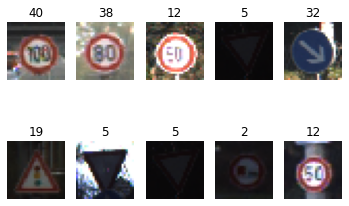

In [182]:
for i in range(10):
  plt.subplot(2, 5, i + 1)

  rand_idx = np.random.randint(X_train_batch.shape[0])
  image = X_train_batch[rand_idx]
  
  plt.imshow(image)
  plt.axis('off')
  plt.title(np.argmax(y_train_batch[rand_idx]))

plt.show()

# Choosing a model

In [197]:
input_shape = X_train_batch[0].shape

# model = keras.Sequential([
#  keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
#  keras.layers.MaxPool2D(),
#  keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'),
#  keras.layers.MaxPool2D(),
#  keras.layers.Flatten(),
#  keras.layers.Dropout(0.5),
#  keras.layers.Dense(units=CLASSES, activation='softmax')
# ])

model = keras.models.Sequential([ # lenet_5_model
    keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', input_shape=input_shape, padding='same'), #C1
    keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'),
    keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(), #S2
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(32, kernel_size=5, strides=1, activation='relu', padding='same'),
    keras.layers.Conv2D(32, kernel_size=5, strides=1, activation='relu', padding='same'),
    keras.layers.Conv2D(32, kernel_size=5, strides=1, activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(), #S4
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(), #Flatten
    keras.layers.Dropout(0.85),
    keras.layers.Dense(CLASSES, activation='softmax') #Output layer
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_212 (Conv2D)          (None, 28, 28, 16)        1216      
_________________________________________________________________
conv2d_213 (Conv2D)          (None, 28, 28, 16)        6416      
_________________________________________________________________
conv2d_214 (Conv2D)          (None, 28, 28, 16)        6416      
_________________________________________________________________
batch_normalization_30 (Batc (None, 28, 28, 16)        64        
_________________________________________________________________
max_pooling2d_104 (MaxPoolin (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_67 (Dropout)         (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_215 (Conv2D)          (None, 14, 14, 32)      

# Training

In [198]:
model.fit(
    x=train_generator,
    validation_data=val_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_steps = val_generator.samples // BATCH_SIZE,
    epochs = 100
)

Epoch 1/100
744/744 [==============================] - 15s 20ms/step - loss: 4.1193 - accuracy: 0.0938 - val_loss: 4.9007 - val_accuracy: 0.0000e+00
Epoch 2/100
744/744 [==============================] - 14s 19ms/step - loss: 3.1308 - accuracy: 0.1821 - val_loss: 5.1434 - val_accuracy: 0.0000e+00
Epoch 3/100
744/744 [==============================] - 15s 20ms/step - loss: 1.8305 - accuracy: 0.4748 - val_loss: 4.8596 - val_accuracy: 0.0856
Epoch 4/100
744/744 [==============================] - 15s 20ms/step - loss: 1.0371 - accuracy: 0.6770 - val_loss: 4.9128 - val_accuracy: 0.2713
Epoch 5/100
744/744 [==============================] - 15s 20ms/step - loss: 0.6891 - accuracy: 0.7838 - val_loss: 3.7585 - val_accuracy: 0.4733
Epoch 6/100
744/744 [==============================] - 15s 20ms/step - loss: 0.5062 - accuracy: 0.8428 - val_loss: 4.6505 - val_accuracy: 0.4703
Epoch 7/100
744/744 [==============================] - 15s 20ms/step - loss: 0.3818 - accuracy: 0.8826 - val_loss: 4.5417 

# Evaluation

In [ ]:
#Predicting the classes of images
test_generator.reset()
predictions = model.predict(test_generator)
print('predictions shape:', predictions.shape)

# getting the labels

pred_labels = list(np.argmax(predictions, axis=1))
predicted_class_indices=np.argmax(predictions,axis=1)

# getting true labels
true_labels = test_generator.classes

# get the confusion plot

cm = confusion_matrix(true_labels, pred_labels)
cm

# labels = (train_generator.class_indices)
# labels = dict((v,k) for k,v in labels.items())
# predictions = [labels[k] for k in predicted_class_indices]
# predictions


In [225]:
model.evaluate(test_generator)

1/1 [==============================] - 3s 3s/step - loss: 0.4673 - accuracy: 0.9508


[0.4673399031162262, 0.9508313536643982]